## 2. Python API Training - Advanced Feature Manipulation [Solution]

<b>Author:</b> Thodoris Petropoulos <br>
<b>Contributors:</b> Rajiv Shah

This is the 2nd exercise to complete in order to finish your `Python API Training for DataRobot` course! This exercise will help you learn how to do advanced feature manipulation to increase model accuracy and make your models more parsimonious by reducing the numbers of features they are using.

Here are the actual sections of the notebook alongside time to complete: 

1. Connect to DataRobot. [3min]<br>
2. Retrieve the Project created during the `Feature Selection Curves` exercise. [5min]<br>
3. Retrieve FI for the top 5 models trained on the `Informative Features` Feature list. [30min]<br>
4. Plot the top 5 features by median FI scores. Then create two lists with top 10 and top 20 features.[15min]
5. Run the best non-blender model using 100% of the sample data on the newly created feature lists. [7min]
6. Compare the newly trained models. Which one has the highest AUC validation score?. [7min]
7. Bonus Question.

Each section will have specific instructions so do not worry if things are still blurry!

As always, consult:

- [API Documentation](https://datarobot-public-api-client.readthedocs-hosted.com)
- [Samples](https://github.com/datarobot-community/examples-for-data-scientists)
- [Tutorials](https://github.com/datarobot-community/tutorials-for-data-scientists)

The last two links should provide you with the snippets you need to complete most of these exercises.

<b>Data</b>

The dataset we will be using throughout these exercises is the well-known `readmissions dataset`. You can access it or directly download it through DataRobot's public S3 bucket [here](https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes.csv).

### Import Libraries
Import libraries here as you start finding out what libraries are needed. The DataRobot package is already included for your convenience.

In [21]:
import datarobot as dr

#Proposed Libraries needed
import pandas as pd
import time
import seaborn as sns
from matplotlib import pyplot as plt

### 1. Connect to DataRobot [3min]

In [2]:
#Possible solution
dr.Client(config_path='../../github/config.yaml')

### 2. Retrieve the Project created during the `Feature Selection Curves` exercise. [5min]<br>

Retrieve the project you created using the readmissions dataset and save it into a variable called `project`.

**Hint 1**: To use a project created in DataRobot you can either list all of the available projects using the Python api or find the ID from the web interface. For example, if you are logged into DataRobot, your browser will be pointing to a link such as this: `https//:YOUR_HOSTNAME/projects/PROJECT_ID/models/MODEL_ID`. Just copy paste the `PROJECT_ID`.

**Hint 2**: Check the `datarobot.Project.get` method. That should help you retrieve your DataRobot project.

In [13]:
#Proposed Solution
project = dr.Project.get('YOUR_PROJECT_ID')

### 3. Retrieve FI for the top 5 models trained on the `Informative Features` Feature list. [30min]<br>

**Instructions**:
- Create a list of the top 5 models based on the `validation` score.
- Make sure that these models have been trained using the `informative features` list


In [14]:
#Proposed Solution

#Get all models
all_models = project.get_models()

#Take top 5 models
filtered_models = [model for model in all_models if model.featurelist_name == 'Informative Features'][0:5]

#Retrieve FI
all_impact = pd.DataFrame()
for model in filtered_models:
    
    # This can take a minute (for each)
    feature_impact = model.get_or_request_feature_impact(max_wait=600)
    
    # Ready to be converted to DF
    df = pd.DataFrame(feature_impact)
    # Track model name and ID for bookkeeping purposes
    df['model_type'] = model.model_type
    df['model_id'] = model.id
    
    # By sorting and re-indexing, the new index becomes our 'ranking'
    df = df.sort_values(by='impactUnnormalized', ascending=False)
    df = df.reset_index(drop=True)
    df['rank'] = df.index.values
    
    # Add to our master list of all models' feature ranks
    all_impact = pd.concat([all_impact, df], ignore_index=True)

### 4. Plot the top 5 features by median FI scores. Then create two lists with top 10 and top 20 features.[15min]

**Instructions**
1. Aggregate the results you retrieved from Feature Impact to calculate the top 10 and top 20 features. 
2. Create two DataRobot feature lists `top_10_aggregated` and `top_20_aggregated`.
3. Plot the top 10 features with their FI score.

**Hint**: There is some sample code for plotting Feature Impact within [Samples](https://github.com/datarobot-community/examples-for-data-scientists).

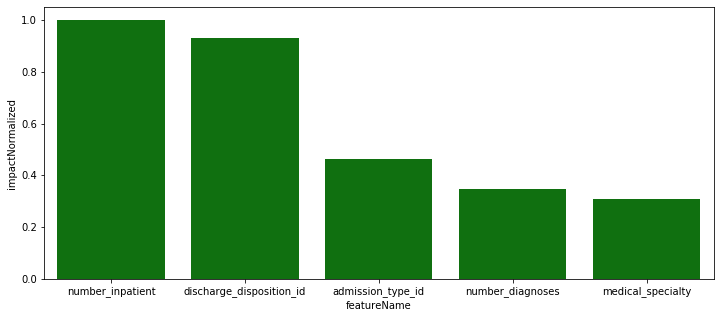

In [25]:
#Save top 10 features
top_10_feats = list(all_impact
                 .groupby('featureName')
                 .median()
                 .sort_values('rank')
                 .head(10)
                 .index
                 .values)

#Save top 20 features
top_20_feats = list(all_impact
                 .groupby('featureName')
                 .median()
                 .sort_values('rank')
                 .head(20)
                 .index
                 .values)

top_10_aggregated = project.create_featurelist('top_10_aggregated', features=top_10_feats)
top_20_aggregated = project.create_featurelist('top_20_aggregated', features=top_20_feats)

#Plot top 5 features
temp = all_impact.groupby('featureName').median().sort_values('rank').head(5).reset_index()

fig, ax = plt.subplots(figsize = (12,5))                  
sns.barplot(x='featureName', y='impactNormalized', data=temp, color='g')

We basically bult a 'wisdom of the crowds' process that provides us with the most impactful features based on multiple models. We could also run the same process between projects with different seeds. This can be especially helpful in wide datasets.

### 5. Run the best non-blender model using 100% of the sample data on the newly created feature lists. [7min]

**Hint**: You will first need to unlock project holdout to be able to train the models on 100% of the data.

**Hint 2**: Do not forget to wait until your model’s training is complete.

In [18]:
#Proposed Solution

project.unlock_holdout()
best_model = filtered_models[0]

best_model.train(sample_pct = 100, featurelist_id = top_10_aggregated.id)
best_model.train(sample_pct = 100, featurelist_id = top_20_aggregated.id)

#Wait for calculations to finish
while len(project.get_all_jobs()) > 0:
    time.sleep(5)

### 6. Compare the newly trained models. Which one has the highest AUC validation score?. [7min]

1. Query all of the models.
2. Find the models that we need (trained on the specific feature lists.
3. Print the accuracy metric for each one of them.

In [19]:
all_models = project.get_models()

for model in all_models:
    if 'top_10_aggregated' == model.featurelist_name:
        print('Accuracy with top_10 features:', model.metrics['AUC']['validation'])
        
    if 'top_20_aggregated' == model.featurelist_name:
        print('Accuracy with top_20 features:', model.metrics['AUC']['validation'])

Accuracy with top_20 features: 0.70867
Accuracy with top_10 features: 0.6911
Accuracy with top_20 features: 0.57185
Accuracy with top_10 features: 0.54807
Accuracy with top_20 features: 0.54631


### Verification
To verify that you have completed everything correctly, look at the AUC Validation score for the best model when trained on the new featurelists. Is the highest AUC `0.70`?

### Bonus Question

1. Why is the number of models trained more than 2? Can you guess? 
2. Combine the result from the Feature Impact exercise with the feature association matrix. What is the average Feature Impact per cluster? Plot the results.

#### Bonus Question Answer (1)

Our best model is an `eXtreme Gradient...` model and it leverages a seperate `Auto-tune....` model. The second model also appears in the leaderboard as a standalone model but it's accuracy is inferior.

#### Bonus Question Answer (2)

In [26]:
#Retrieve association information
associations = project.get_associations(assoc_type='association', metric = 'mutualInfo')

#Retrieve clusters information
clusters = pd.DataFrame.from_records(associations['features'])
clusters.head()

,alphabetic_sort_index,cluster_id,cluster_name,cluster_sort_index,feature,importance_sort_index,strength_sort_index
0,3,1.0,admission_source_id cluster,0,admission_type_id,7,7
1,2,1.0,admission_source_id cluster,1,admission_source_id,5,5
2,17,0.0,insulin cluster,2,insulin,14,9
3,19,0.0,insulin cluster,3,metformin,34,17
4,7,0.0,insulin cluster,4,diabetesMed,20,4


In [28]:
#Join Feature Impact with cluster information
merged = all_impact.merge(clusters,how = 'left',left_on ='featureName', right_on = 'feature')
merged['cluster_id'] = merged['cluster_id'].fillna(-1)

#Get average impact per cluster
temp = merged.groupby('cluster_id').mean().reset_index()
temp.head()

,cluster_id,impactNormalized,impactUnnormalized,rank,alphabetic_sort_index,cluster_sort_index,importance_sort_index,strength_sort_index
0,-1.0,0.116589,0.003454,22.383333,19.210526,24.315789,21.842105,23.842105
1,0.0,0.033944,0.001136,27.200000,12.000000,3.500000,21.250000,9.000000
2,1.0,0.341838,0.009510,6.200000,2.500000,0.500000,6.000000,6.000000
3,2.0,0.319861,0.009377,9.177778,16.222222,10.000000,9.222222,7.222222


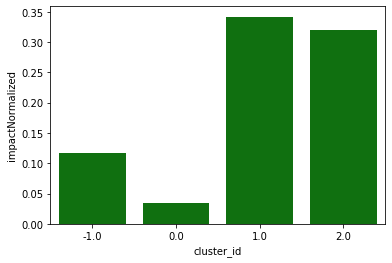

In [30]:
#Plot results
sns.barplot(x='cluster_id', y='impactNormalized', data=temp, color='g')